In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import io
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# DATA Loading

In [3]:
path = "/content/drive/MyDrive/data/employeereview/"

In [4]:
bio = BytesIO()
with open(path+"EmployeeReview.csv", 'rb') as f:
   bio.write(f.read())
bio.seek(0)
df = pd.read_csv(bio, lineterminator='\n')

In [5]:
df.head()

,review_id,company_name,review_title,job_title,employee_status,location,date,review,pros,cons,rating,yes_helpful,no_helpful\r
0,0,Startup1,Great place to work,Lead Financial Analyst,Former Employee,"Bengaluru, Karnataka",2020-04-03,Great place to work. Team is very supportive a...,NaN,NaN,5.0,0,0
1,1,Startup1,Work life balance is excellent,Advisory System Analyst,Current Employee,"Bangalore, Karnataka",2020-04-02,Good company to work for ladies. But the compa...,NaN,NaN,3.0,0,0
2,2,Startup1,I have worked in a wonderful organisation,Senior BSS Analyst,Former Employee,"NCR, Delhi",2020-04-02,I have worked in a wonderful organisation and ...,NaN,NaN,5.0,0,0
3,3,Startup1,Worklife balance and flexibility for women in ...,Quality Assurance Specialist,Former Employee,"Bengaluru, Karnataka",2020-03-26,Worklife balance and flexibility for women in ...,NaN,NaN,5.0,0,0
4,4,Startup1,Good Place to Work,Management Consultant,Former Employee,London,2020-03-26,"Diverse environment, clients and people. Ex...",NaN,NaN,5.0,0,0


In [6]:
df.shape

(27230, 13)

In [7]:
#Check for null entries
df.isnull().sum(axis=0)

review_id              0
company_name           0
review_title          25
job_title             15
employee_status        0
location              21
date                   0
review                 0
pros               14119
cons               14659
rating                 0
yes_helpful            0
no_helpful\r           0
dtype: int64

## Data Cleaning

In [8]:
df['review_title'].fillna(df['company_name'], inplace = True)

In [9]:
 #remove rows with no job_title
 df = df.dropna(axis = 0, subset = ['job_title'])

In [10]:
 #remove rows with no job_title
 df = df.dropna(axis = 0, subset = ['location'])

In [11]:
#drop pros & cons columns, as more than half column values are Nan
#df = df.drop(['pros','cons'], axis = 1)
df['pros'].fillna(" ", inplace = True)
df['cons'].fillna(" ", inplace = True)

In [12]:
#Check for null entries
df.isnull().sum(axis=0)

review_id          0
company_name       0
review_title       0
job_title          0
employee_status    0
location           0
date               0
review             0
pros               0
cons               0
rating             0
yes_helpful        0
no_helpful\r       0
dtype: int64

In [13]:
df.shape

(27196, 13)

In [14]:
#change review time to type datetime for later modifications
df = df.astype({'date': 'datetime64[ns]'})

In [15]:
df.head()

,review_id,company_name,review_title,job_title,employee_status,location,date,review,pros,cons,rating,yes_helpful,no_helpful\r
0,0,Startup1,Great place to work,Lead Financial Analyst,Former Employee,"Bengaluru, Karnataka",2020-04-03,Great place to work. Team is very supportive a...,,,5.0,0,0
1,1,Startup1,Work life balance is excellent,Advisory System Analyst,Current Employee,"Bangalore, Karnataka",2020-04-02,Good company to work for ladies. But the compa...,,,3.0,0,0
2,2,Startup1,I have worked in a wonderful organisation,Senior BSS Analyst,Former Employee,"NCR, Delhi",2020-04-02,I have worked in a wonderful organisation and ...,,,5.0,0,0
3,3,Startup1,Worklife balance and flexibility for women in ...,Quality Assurance Specialist,Former Employee,"Bengaluru, Karnataka",2020-03-26,Worklife balance and flexibility for women in ...,,,5.0,0,0
4,4,Startup1,Good Place to Work,Management Consultant,Former Employee,London,2020-03-26,"Diverse environment, clients and people. Ex...",,,5.0,0,0


In [16]:
#let's check if there are any duplicate rows
df.duplicated().sum()

0

In [17]:
#removing duplicates
df.drop_duplicates(inplace=True)

In [18]:
#what are the features?
df.columns

Index(['review_id', 'company_name', 'review_title', 'job_title',
       'employee_status', 'location', 'date', 'review', 'pros', 'cons',
       'rating', 'yes_helpful', 'no_helpful\r'],
      dtype='object')

In [19]:
#df.rename(columns = {'Unnamed: 0':'reviewID'}, inplace = True)

In [20]:
#let's first see how many reviews are posted per reviewer
df["company_name"].value_counts()

Startup1    27196
Name: company_name, dtype: int64

In [21]:
df.head()

,review_id,company_name,review_title,job_title,employee_status,location,date,review,pros,cons,rating,yes_helpful,no_helpful\r
0,0,Startup1,Great place to work,Lead Financial Analyst,Former Employee,"Bengaluru, Karnataka",2020-04-03,Great place to work. Team is very supportive a...,,,5.0,0,0
1,1,Startup1,Work life balance is excellent,Advisory System Analyst,Current Employee,"Bangalore, Karnataka",2020-04-02,Good company to work for ladies. But the compa...,,,3.0,0,0
2,2,Startup1,I have worked in a wonderful organisation,Senior BSS Analyst,Former Employee,"NCR, Delhi",2020-04-02,I have worked in a wonderful organisation and ...,,,5.0,0,0
3,3,Startup1,Worklife balance and flexibility for women in ...,Quality Assurance Specialist,Former Employee,"Bengaluru, Karnataka",2020-03-26,Worklife balance and flexibility for women in ...,,,5.0,0,0
4,4,Startup1,Good Place to Work,Management Consultant,Former Employee,London,2020-03-26,"Diverse environment, clients and people. Ex...",,,5.0,0,0


#Data Exploration

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


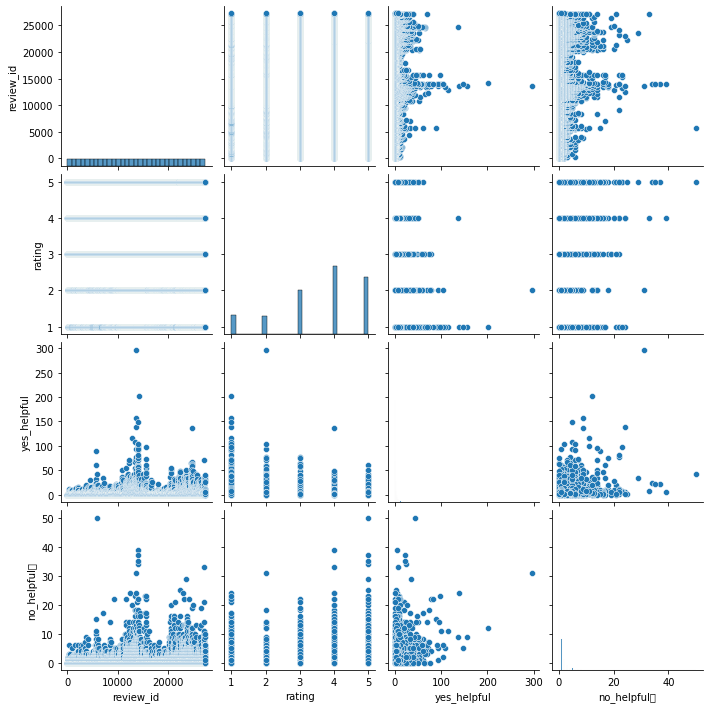

In [22]:
plt.figure()
sns.pairplot(df)
plt.show()

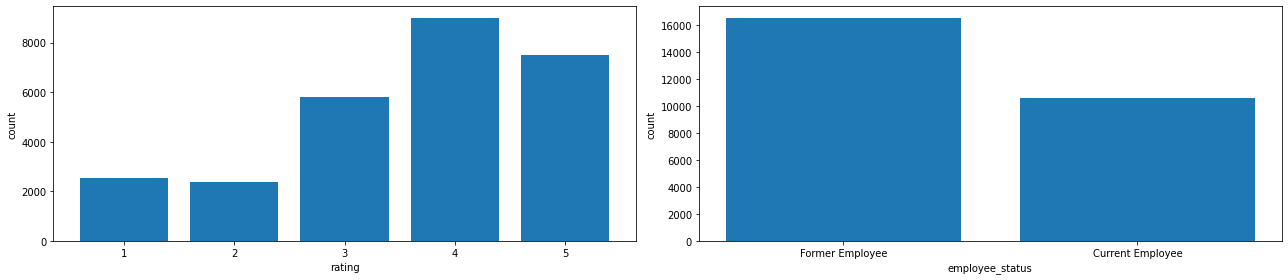

In [23]:
#let's look at the distributions of ratings, verified purchases, and helpful votes.
plt.subplots(1,2, figsize=(18,4))

plt.subplot(1,2,1)
plt.bar(df['rating'].value_counts().index, df['rating'].value_counts().values)
plt.xlabel('rating')
plt.ylabel('count')

plt.subplot(1,2,2)
plt.bar(df['employee_status'].value_counts().index, df['employee_status'].value_counts().values)
plt.xlabel('employee_status')
plt.ylabel('count')

plt.tight_layout()
plt.show()

In [24]:
#reviews, products, reviewers
print(f'Reviews: {len(df)}')
print(f'JobTitle: {len(df["job_title"].value_counts())}') 
print(f'Location: {len(df["location"].value_counts())}')
print(f'Company Name: {len(df["company_name"].value_counts())}')

Reviews: 27196
JobTitle: 15289
Location: 6034
Company Name: 1


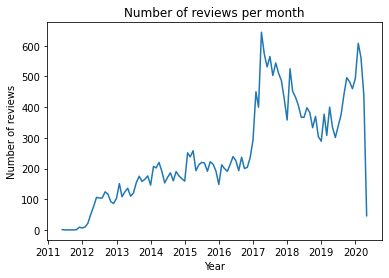

In [25]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
plt.plot(df['review'].resample('M').count())
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per month')
plt.show()

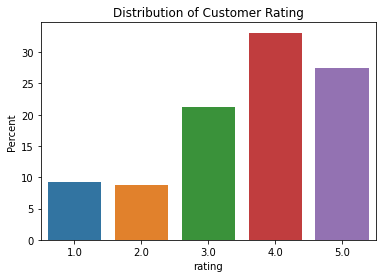

In [26]:
ax = sns.barplot(data=df, x='rating', y='rating', estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

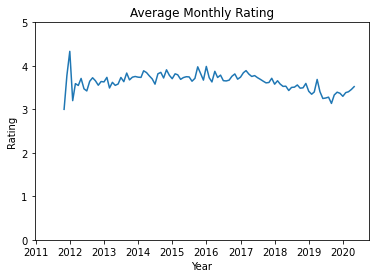

In [27]:
plt.plot(df['rating'].resample('M').mean())
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average Monthly Rating')
plt.ylim(0,5)
plt.show()

#Pre-Modeling

In [28]:
ENGLISH_STOP_WORDS = stopwords.words('english')

In [29]:
def spl_tokenizer(sentence):
    '''
    Tokenizer with following specs:
    - removes english stopwords
    - removes punctuation
    - lemmatizes words
    '''
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmatized_words = []
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatize words
            token = WordNetLemmatizer().lemmatize(word)            
            
            #append token to list
            listoflemmatized_words.append(token)

    return listoflemmatized_words



In [30]:
def sps_tokenizer(sentence):
    '''
    Tokenizer with following specs:
    - removes english stopwords
    - removes punctuation
    - stems words
    '''
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    #instantiate stemmer
    stemmer = PorterStemmer() 

    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatize words
            token = stemmer.stem(word)  

            #append token to list
            listofstemmed_words.append(token)

    return listofstemmed_words

In [31]:
def tfidf(dataframe_column, tokenizer, min_df=0.02, max_df=0.8, ngram_range=(1,1)):

    #0. For tokenization, need to determine what prefix (r_ or s_) to add to each token
    #To do so, retrieve the name of the column from which the tokens are generated
    column_name = dataframe_column.name
    #Next, assign an attribute (called type) to the tfidf function to indicate if the tokens are from review or summary
    if column_name == 'review':
        tfidf.type = 'review'
    else:
        tfidf.type = 'none'

    # 1. Instantiate  (stop_words='english')
    vectorizer = TfidfVectorizer(min_df = min_df, max_df = max_df, tokenizer = tokenizer, ngram_range = ngram_range)
    
    # 2. Fit 
    vectorizer.fit(dataframe_column)
    
    # 3. Transform
    reviews_tokenized = vectorizer.transform(dataframe_column)
    
    # We extract the information and put it in a data frame
    tokens = pd.DataFrame(columns=vectorizer.get_feature_names(), data=reviews_tokenized.toarray())
    
    return tokens

In [32]:
#obtaining number of tokens using tf idf vectorization based on varying min_df values for review text 
#using lemmatization or stemming
min_df_list = range(250,2001,250)
numTokens_lem = []
numTokens_stem = []

for i in min_df_list:
    
    #getting number of tokens using tf idf vectorizer using lemmatization or stemming
    print(f'beginning tokenization with min_df = {i}')
    tokens_l = (tfidf(df['review'], tokenizer=spl_tokenizer, min_df=i, ngram_range=(1,2))).shape[1]
    print(f'vectorization with lemmatization for min_df = {i} complete')
    tokens_s = (tfidf(df['review'], tokenizer=sps_tokenizer, min_df=i, ngram_range=(1,2))).shape[1]
    print(f'vectorization with stemming for min_df = {i} complete')

    #appending number of tokens to the appropriate list
    numTokens_lem.append(tokens_l)
    numTokens_stem.append(tokens_s)
    print(f'number of tokens appending to corresponding list. min_df = {i} complete')

beginning tokenization with min_df = 250


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 250 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with stemming for min_df = 250 complete
number of tokens appending to corresponding list. min_df = 250 complete
beginning tokenization with min_df = 500


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 500 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with stemming for min_df = 500 complete
number of tokens appending to corresponding list. min_df = 500 complete
beginning tokenization with min_df = 750


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 750 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with stemming for min_df = 750 complete
number of tokens appending to corresponding list. min_df = 750 complete
beginning tokenization with min_df = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 1000 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with stemming for min_df = 1000 complete
number of tokens appending to corresponding list. min_df = 1000 complete
beginning tokenization with min_df = 1250


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 1250 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with stemming for min_df = 1250 complete
number of tokens appending to corresponding list. min_df = 1250 complete
beginning tokenization with min_df = 1500


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 1500 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with stemming for min_df = 1500 complete
number of tokens appending to corresponding list. min_df = 1500 complete
beginning tokenization with min_df = 1750


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 1750 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with stemming for min_df = 1750 complete
number of tokens appending to corresponding list. min_df = 1750 complete
beginning tokenization with min_df = 2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


vectorization with lemmatization for min_df = 2000 complete
vectorization with stemming for min_df = 2000 complete
number of tokens appending to corresponding list. min_df = 2000 complete


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


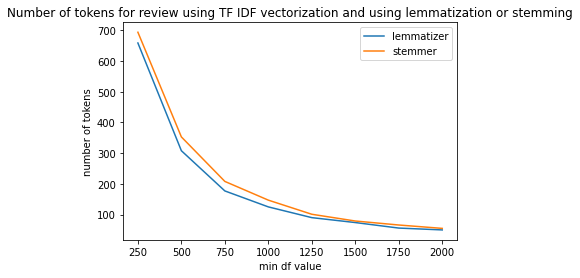

In [33]:
#plot num tokens for each tokenizer with varying min df values
plt.figure()
plt.plot(min_df_list, numTokens_lem, label='lemmatizer')
plt.plot(min_df_list, numTokens_stem, label='stemmer')
plt.legend()
plt.xlabel('min df value')
plt.ylabel('number of tokens')
plt.title('Number of tokens for review using TF IDF vectorization and using lemmatization or stemming')
plt.show()

In [34]:
#2. Scaling non-token Features
#Let's try using 3 different scalers and see how the change the data. Namely:
# - MinMaxScaler
# - RobustScaler
# - StandardScaler


In [35]:
#let's grab all the numeric features (no tokens)
df2=df.select_dtypes(include=['int32','int64'])

In [36]:
# MinMaxScaler

In [37]:
from sklearn.preprocessing import MinMaxScaler
#instantiate min max scaler
mm = MinMaxScaler()
#fit transform data to min max scaler
df3 = mm.fit_transform(df2)
#let's view quartiles of the features
pd.DataFrame(df3, columns = df2.columns).describe()

,review_id,yes_helpful,no_helpful\r
count,27196.000000,27196.000000,27196.000000
mean,0.500044,0.006986,0.011200
std,0.288706,0.019418,0.032563
min,0.000000,0.000000,0.000000
25%,0.249982,0.000000,0.000000
50%,0.500110,0.003367,0.000000
75%,0.750092,0.006734,0.020000
max,1.000000,1.000000,1.000000


In [38]:
# Robust Scaler

In [39]:
from sklearn.preprocessing import RobustScaler
#instantiate
rs = RobustScaler(with_centering=False)
#fit transform using robust scaler
df3 = rs.fit_transform(df2)
pd.DataFrame(df3, columns=df2.columns).describe()

,review_id,yes_helpful,no_helpful\r
count,27196.000000,27196.000000,27196.000000
mean,0.999868,1.037414,0.560009
std,0.577284,2.883569,1.628157
min,0.000000,0.000000,0.000000
25%,0.499853,0.000000,0.000000
50%,1.000000,0.500000,0.000000
75%,1.499853,1.000000,1.000000
max,1.999559,148.500000,50.000000


In [40]:
# Standard Scaler

In [41]:
from sklearn.preprocessing import StandardScaler
#instantiate
ss = StandardScaler()
df3 = ss.fit_transform(df2)
pd.DataFrame(df3, columns = df2.columns).describe()

,review_id,yes_helpful,no_helpful\r
count,2.719600e+04,2.719600e+04,2.719600e+04
mean,-1.914763e-16,-2.333713e-14,5.751944e-16
std,1.000018e+00,1.000018e+00,1.000018e+00
min,-1.732054e+00,-3.597738e-01,-3.439590e-01
25%,-8.661671e-01,-3.597738e-01,-3.439590e-01
50%,2.282305e-04,-1.863744e-01,-3.439590e-01
75%,8.661148e-01,-1.297499e-02,2.702438e-01
max,1.731747e+00,5.113985e+01,3.036618e+01


#PCA and Modelling

In [42]:
#1. Perform Tokenization
# For review Text, will use: lemmatizer, ngrams 1-2, min_df = 1000
# For review_title, will use: lemmatizer, ngrams 1-2, min_df = 800

In [43]:
#getting review tokens which will be prepended with 'r_'
review_tokens = tfidf(df['review'], tokenizer=spl_tokenizer, ngram_range=(1,2), min_df=1000)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
# Scale numeric features
# Will be using the MinMaxScaler to scale the non-token features.

In [45]:
#getting the numeric features (no tokens)
df2=df.select_dtypes(include=['int32','int64'])

In [46]:
#instantiate minmaxscaler
mm = MinMaxScaler()
#fit transform data using minmaxscaler
df3 = mm.fit_transform(df2)
#put the scaled into a dataframe
df_scaled = pd.DataFrame(df3, columns = df2.columns)
df_scaled.shape

(27196, 3)

In [47]:
#saving memory
del df3, df2

In [48]:
# Now let's bring in the tokens to get the final dataframe.

#concatenating the scaled non-token features and the review & summary tokens
df_final = pd.concat([df_scaled, review_tokens], axis = 1)

#save data
df_final.to_csv('all_tokens_scaled.zip', compression='zip')

df_final.tail()

,review_id,yes_helpful,no_helpful\r,\r,able,also,always,amazon,back,balance,balanced,based,benefit,best,business,call,care,career,change,client,come,company,company work,could,coworkers,culture,customer,day,difference,different,diverse,diversity,dont,employee,enjoyable,enjoyable part,enjoyed,environment,even,every,...,part,part job,pay,people,place,place work,position,process,product,professional,project,really,sale,service,skill,start,support,system,take,team,technology,thing,time,training,typical,typical day,u,want,way,well,within,woman,work,work environment,work life,worked,working,workplace,would,year
27191,0.999853,0.020202,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.173509,0.000000,0.0,0.132537,0.0,0.0,0.146627,0.0,0.000000,0.239590,0.164469,0.176644,0.0,0.136770,0.0,0.0,...,0.263919,0.000000,0.0,0.122883,0.000000,0.000000,0.0,0.0,0.390669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.178342,0.189136,0.0,0.0,0.0,0.156129,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
27192,0.999890,0.006734,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.196523,0.130647,0.179368,0.192646,0.0,0.000000,0.0,0.0,...,0.287827,0.347947,0.0,0.000000,0.274280,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.199432,0.0,0.0,0.0,0.139617,0.177074,0.194498,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.164893,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
27193,0.999927,0.006734,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.216079,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.262907,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.275973,0.353737,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.165911,0.00000,0.0,0.339698,0.0,0.0,0.0,0.0
27194,0.999963,0.006734,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
27195,1.000000,0.020202,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260454,0.0,0.000000,0.0,0.0,0.000000,0.207037,0.0,0.000000,0.0,0.0,0.227110,0.0,0.000000,0.000000,0.254745,0.273603,0.0,0.211842,0.0,0.0,...,0.408783,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.234187,0.30365,0.0,0.000000,0.0,0.0,0.0,0.0


In [49]:
# Since the number of features are only 143, we may not need to perform PCA

# K-Means Clustering

In [50]:
from sklearn.cluster import KMeans
import sklearn

In [51]:
#we begin by trying to determine the optimal number of clusters by looking at inertia scores
#cycle through different K values and append inertia score to list
k_values = range(8,32)
inertia_scores = []

for k in k_values:
    #instantiate
    kmeans_model = sklearn.cluster.KMeans(n_clusters=k, verbose=1)
    #fitting of dataset
    kmeans_model.fit(df_final)
    #get scores and append them
    inertia = kmeans_model.inertia_
    #append score
    inertia_scores.append(inertia)

Streaming output truncated to the last 5000 lines.
Iteration 6, inertia 21458.967454112295
Iteration 7, inertia 21400.74649545589
Iteration 8, inertia 21362.97807806734
Iteration 9, inertia 21342.702473071902
Iteration 10, inertia 21331.380927299746
Iteration 11, inertia 21324.24564630042
Iteration 12, inertia 21319.655900993705
Iteration 13, inertia 21316.862422629973
Iteration 14, inertia 21314.856499678768
Iteration 15, inertia 21313.393446298556
Iteration 16, inertia 21312.324002033005
Iteration 17, inertia 21311.351870111204
Iteration 18, inertia 21310.19118973827
Iteration 19, inertia 21308.795981069445
Iteration 20, inertia 21307.503792721047
Iteration 21, inertia 21306.00177498938
Iteration 22, inertia 21305.08624615888
Iteration 23, inertia 21304.596219993018
Iteration 24, inertia 21304.355848274266
Iteration 25, inertia 21304.214494891938
Iteration 26, inertia 21304.09379051337
Iteration 27, inertia 21303.93171954222
Iteration 28, inertia 21303.772429758166
Iteration 29, iner

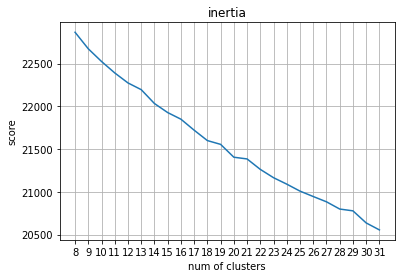

In [52]:
plt.figure()
plt.plot(k_values, inertia_scores)
plt.xlabel('num of clusters')
plt.ylabel('score')
plt.title('inertia')
plt.xticks(k_values)
plt.grid()
#plt.ylim(0,580000)
plt.show()

In [53]:
#Based on the graph, there is a decrease in the slope at the following number of clusters: 15, 17, 24.

In [54]:
#View Cluster Features
#17 has lowest inertia, hence view features with 17 clusters

In [55]:
#instantiate KMeans with 17 clusters
kmeans_model25 = KMeans(n_clusters=17, verbose=1)
#fitting KMeans of dataset
kmeans_model25.fit(df_final)

Initialization complete
Iteration 0, inertia 31507.214687875785
Iteration 1, inertia 23041.698770540184
Iteration 2, inertia 22517.73588743093
Iteration 3, inertia 22296.940405865367
Iteration 4, inertia 22161.549848889612
Iteration 5, inertia 22082.518167312774
Iteration 6, inertia 22017.76763224345
Iteration 7, inertia 21963.5840464877
Iteration 8, inertia 21928.108212637606
Iteration 9, inertia 21907.53166029538
Iteration 10, inertia 21897.66134712811
Iteration 11, inertia 21892.354872201708
Iteration 12, inertia 21887.831202375415
Iteration 13, inertia 21883.62414168624
Iteration 14, inertia 21878.69585041483
Iteration 15, inertia 21872.4740965537
Iteration 16, inertia 21865.90915187388
Iteration 17, inertia 21859.273978019737
Iteration 18, inertia 21853.75481699108
Iteration 19, inertia 21849.320576086608
Iteration 20, inertia 21845.515852367083
Iteration 21, inertia 21842.83542147586
Iteration 22, inertia 21841.008978749713
Iteration 23, inertia 21839.35996225348
Iteration 24, in

KMeans(n_clusters=17, verbose=1)

In [56]:
kmeans_model25.labels_

array([ 8, 10,  7, ...,  1,  4,  6], dtype=int32)

#LDA Topic Modeling with 24 topics

In [57]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Setting number of topics and also the top number of words we want to see from the model
number_topics = 24
number_words = 15

In [58]:
#bringing in just the reviewText from the dataset (require custom functions library)
review = df['review']

In [59]:
#make sure it's loaded in properly
review

date
2020-04-03    Great place to work. Team is very supportive a...
2020-04-02    Good company to work for ladies. But the compa...
2020-04-02    I have worked in a wonderful organisation and ...
2020-03-26    Worklife balance and flexibility for women in ...
2020-03-26    Diverse environment, clients and people.    Ex...
                                    ...                        
2012-05-03    A typical day was reading packing slip to get ...
2012-04-17    ~Typical work night includes managing producti...
2012-03-07    I loved the majority of those I worked for and...
2018-09-10    Premiere experience dans un ene societe multin...
2017-06-16    Challenging work environment. Management did n...
Name: review, Length: 27196, dtype: object

In [60]:
#using same settings used for KMeans clustering to be consistent
vectorizer = TfidfVectorizer(min_df = 1000, tokenizer = spl_tokenizer, ngram_range = (1,2))

In [61]:
#get tokens from reviewText
word_matrix = vectorizer.fit_transform(review)

In [62]:
# Helper function\
#source: https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Introduction%20to%20Topic%20Modeling.ipynb
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(",".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [63]:
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=4, verbose=1)
lda.fit(word_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=24, n_jobs=4, verbose=1)

In [64]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
environment,work environment,work,good,employee,diverse,company,management,working,team,great,fun,opportunity,training,culture

Topic #1:
service,customer,support,product,system,call,team,issue,management,client,new,company,process,business,sale

Topic #2:
hour,long,time,day,work,job,back,would,get,go,working,management,people,employee,company

Topic #3:
international,business,technology,process,company,service,client,experience,new,team,working,work,management,good,opportunity

Topic #4:
diverse,great,company,people,opportunity,work,made,culture,different,experience,working,many,team,environment,employee

Topic #5:
,come,manager,customer,management,company,team,work,year,job,time,get,people,employee

Topic #6:
diversity,nice,company,people,great,work,culture,good,different,employee,worked,lot,opportunity,within,working

Topic #7:
life,work life,balance,work,good,balanced,company,culture,opportunity,place,employee,woman,great,management,lot

Topic #8:
w